## Amazon Fine Food Review - Support Vector Machine - RBF Algorithm

In [1]:
# Getting all the imports done

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import seaborn as sns

C:\Users\NamrataT\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\NamrataT\Desktop\EXAM\PYTHON\Amazon Fine Food Reviews\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 40000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (40000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
filtered_data['Score'].value_counts()

1    33439
0     6561
Name: Score, dtype: int64

In [4]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.reset_index(drop=True, inplace=True)

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(37415, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

93.5375

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(37415, 10)


1    31324
0     6091
Name: Score, dtype: int64

In [9]:
final_score = final['Score']
final_score.shape

(37415,)

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below','not','no', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 37415/37415 [00:23<00:00, 1584.30it/s]


## 1) Applying Support Vector Machine 

## 1.1) Applying Support Vector Machine on BOW, SET 1

In [13]:
# Getting all the imports done

from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

In [15]:
final['Cleaned_Text']=preprocessed_reviews
#final['Cleaned_Summary'] = preprocessed_summary
final['Word Count'] = final['Cleaned_Text'].apply(lambda x:len(x.split()))
#final['Summary Word Count'] = final['Cleaned_Summary'].apply(lambda x:len(x.split()))
final.head()
word_count = final['Word Count']

In [16]:
# Please write all the code with proper documentation
# TIME BASED SPILTTING
# SIMPLE CROSS VALIDATION

X_1, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
X_1_train, X_1_cv, Y_1_train, Y_1_cv = train_test_split( X_1, Y_1, test_size=0.2,shuffle = False)
print(X_1_train.shape,Y_1_train.shape)

(23945, 1) (23945,)


In [17]:
df_post_split = pd.concat([X_1_train,Y_1_train],axis=1)
x_positive = df_post_split[df_post_split['Score']==1]
x_negetive = df_post_split[df_post_split['Score']==0]

In [18]:
df_post_split['Score'].value_counts()

1    20308
0     3637
Name: Score, dtype: int64

In [19]:
# For every observation of class 1, randomly sample from class 0 without replacement
#x_negetive_upsample = resample(x_negetive, replace = True, n_samples=17000)
x_negative_downsample = resample(x_negetive,replace=True,n_samples=15000,random_state=123) 

In [20]:
print(x_negative_downsample.shape, type(x_positive))

(15000, 2) <class 'pandas.core.frame.DataFrame'>


In [21]:
#df_upsample = pd.concat([x_positive,x_negetive_upsample])
df_upsample = pd.concat([x_positive,x_negative_downsample])
type(df_upsample)
df_upsample.head()

,Cleaned_Text,Score
0,really good idea final product outstanding use...,1
1,received shipment could hardly wait try produc...,1
2,love stuff sugar free rot gums tastes good goi...,1
3,nothing product bother link top page buy used ...,1
4,fresh limes underappreciated joy kitchen squir...,1


In [22]:
df_upsample['Score'].value_counts()

1    20308
0    15000
Name: Score, dtype: int64

In [23]:
X_Train = df_upsample.drop(['Score'],axis=1)
Y_1_train = df_upsample['Score']
print(X_Train.shape, Y_1_train.shape)

(35308, 1) (35308,)


In [24]:
print(X_Train.shape, Y_1_train.shape)

(35308, 1) (35308,)


In [24]:
# BoW -- transform with unigram and bigram

ngram_vect = CountVectorizer(min_df=10, max_features = 500)
D1_Train = ngram_vect.fit_transform(X_Train['Cleaned_Text'])
D1_Cv = ngram_vect.transform(X_1_cv['Cleaned_Text'])
D1_Test = ngram_vect.transform(X_test['Cleaned_Text'])
print(D1_Train.shape,D1_Test.shape)

(35308, 500) (7483, 500)


In [25]:
n_cv = D1_Cv.get_shape()[0]
n_train = D1_Train.get_shape()[0]
n_test = D1_Test.get_shape()[0]
print(n_train)
print(n_test)

35308
7483


In [26]:
# Standardization Process
# Changes done as suggested

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(D1_Train)
D1_Train = scaler.transform(D1_Train)
D1_Cv = scaler.transform(D1_Cv)
D1_Test = scaler.transform(D1_Test)

print(D1_Train.shape)
print(D1_Cv.shape)
print(D1_Test.shape)

C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(35308, 500)
(5987, 500)
(7483, 500)


In [30]:
# Applying SVM

cv_score = []
train_score = []

# creating hyper-parameter list
alpha = list((0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000))

cv_auc = []
train_auc = []
        
for i in tqdm(alpha):
    svm = SVC(random_state = 0, C = i, class_weight='balanced',kernel = 'rbf', probability = True )
    
    # Fitting the model in Train - CrossValidation
    svm.fit(D1_Train,Y_1_train)
    
    predict_cv_prob = []
    predict_train_prob = []
    predicted_labels_test = []
    predicted_labels_train = []
        
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_test.extend(svm.predict(D1_Cv[j:j+1000]))
        predict_cv_prob.extend(svm.predict_proba(D1_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(svm.predict(D1_Train[k:k+1000]))
        predict_train_prob.extend(svm.predict_proba(D1_Train[k:k+1000])[:,1])
    
    print(len(predict_train_prob))
        
    cv_auc.append(roc_auc_score(Y_1_cv,predict_cv_prob))
    train_auc.append(roc_auc_score(Y_1_train,predict_train_prob))


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

35308



 10%|███████▉                                                                       | 1/10 [47:48<7:10:15, 2868.37s/it]

35308



 20%|███████████████▍                                                             | 2/10 [1:35:54<6:23:08, 2873.56s/it]

35308



 30%|███████████████████████                                                      | 3/10 [2:25:16<5:38:22, 2900.33s/it]

35308



 40%|██████████████████████████████▊                                              | 4/10 [3:15:24<4:53:15, 2932.55s/it]

35308



 50%|██████████████████████████████████████▌                                      | 5/10 [4:03:47<4:03:38, 2923.61s/it]

35308



 60%|██████████████████████████████████████████████▏                              | 6/10 [4:57:56<3:21:25, 3021.41s/it]

35308



 70%|█████████████████████████████████████████████████████▉                       | 7/10 [6:02:01<2:43:25, 3268.47s/it]

35308



 80%|█████████████████████████████████████████████████████████████▌               | 8/10 [7:12:07<1:58:19, 3549.51s/it]

35308



 90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [8:15:44<1:00:29, 3629.96s/it]

35308



100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [9:20:08<00:00, 3699.98s/it]


In [33]:
import math
alpha_new = []
for n in range(len(alpha)):
    alpha1 = alpha[n]
    x = math.log(alpha1)
    print(alpha1,x)
    alpha_new.append(x)

1e-05 -11.512925464970229
0.0001 -9.210340371976182
0.001 -6.907755278982137
0.01 -4.605170185988091
0.1 -2.3025850929940455
1 0.0
10 2.302585092994046
100 4.605170185988092
1000 6.907755278982137
10000 9.210340371976184


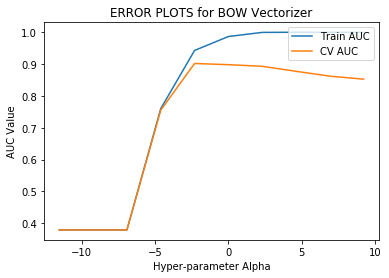

In [34]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(alpha_new,train_auc)
plt.plot(alpha_new,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Alpha')
plt.ylabel('AUC Value')
plt.show()

In [35]:
# Getting the optimal Alpha Based to CV AUC
optimal_lamda_auc = alpha[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best Alpha = %f' % optimal_lamda_auc)
print(best_cv_auc)

AUC Metric Best Alpha = 0.100000
0.902


In [36]:
# Applying Best K on D_Test

svm = SVC(random_state = 0, C = 0.1, class_weight='balanced',kernel = 'rbf', probability = True )
svm.fit(D1_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(svm.predict(D1_Test[j:j+1000]))
    predict_test_prob.extend(svm.predict_proba(D1_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(svm.predict(D1_Train[k:k+1000]))
    predict_train_prob.extend(svm.predict_proba(D1_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)


7483
7483
Algo Run Successfully on D_Test


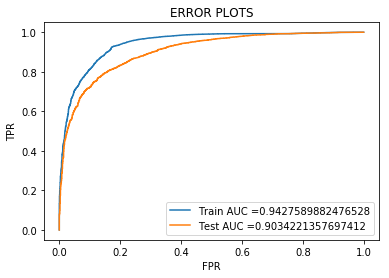

In [37]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [38]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
13641 1359 4200 16108
[[13641  1359]
 [ 4200 16108]]
Test Confusion Matrix
1150 193 1303 4837
[[1150  193]
 [1303 4837]]


##### Heatmap on the model 

Text(0.5,1,'Confusion Matrix of Train Data')

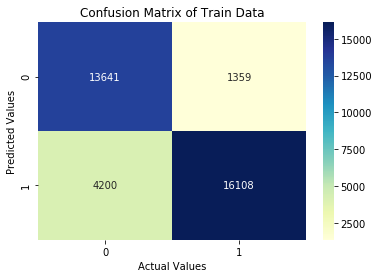

In [39]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

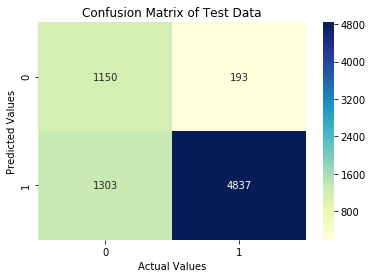

In [40]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

## 1.2) Applying SVM - Linear Kernel on TF-IDF, SET 2

In [25]:
# Creating Tfidf Vectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,2) , min_df = 10, max_features = 500 )
D2_Train = tfidf_vect.fit_transform(X_Train['Cleaned_Text'])
D2_Cv = tfidf_vect.transform(X_1_cv['Cleaned_Text'])
D2_Test = tfidf_vect.transform(X_test['Cleaned_Text'])
print("Some feature names : ", tfidf_vect.get_feature_names()[0:10])
print(D2_Train.shape,D2_Test.shape)

Some feature names :  ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also']
(35308, 500) (7483, 500)


In [26]:
scaler_tfidf = StandardScaler(with_mean=False)
scaler_tfidf.fit(D2_Train)
D2_Train = scaler_tfidf.transform(D2_Train)
D2_Cv = scaler_tfidf.transform(D2_Cv)
D2_Test = scaler_tfidf.transform(D2_Test)
print(D2_Train.shape,D2_Test.shape)

(35308, 500) (7483, 500)


In [27]:
n_test = D2_Test.get_shape()[0]
n_train = D2_Train.get_shape()[0]
n_cv = D2_Cv.get_shape()[0]
print(n_train,n_test,n_cv)

35308 7483 5987


In [28]:
# Applying SVM

cv_score = []
train_score = []

# creating hyper-parameter list
alpha = list((0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000))

cv_auc = []
train_auc = []
        
for i in tqdm(alpha):
    svm = SVC(random_state = 0, C = i, class_weight='balanced',kernel = 'rbf', probability = True )
    
    # Fitting the model in Train - CrossValidation
    svm.fit(D2_Train,Y_1_train)
    
    predict_cv_prob = []
    predict_train_prob = []
    predicted_labels_test = []
    predicted_labels_train = []
        
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_test.extend(svm.predict(D2_Cv[j:j+1000]))
        predict_cv_prob.extend(svm.predict_proba(D2_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(svm.predict(D2_Train[k:k+1000]))
        predict_train_prob.extend(svm.predict_proba(D2_Train[k:k+1000])[:,1])
    
    print(len(predict_train_prob))
        
    cv_auc.append(roc_auc_score(Y_1_cv,predict_cv_prob))
    train_auc.append(roc_auc_score(Y_1_train,predict_train_prob))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

35308


 10%|███████▉                                                                       | 1/10 [56:06<8:25:01, 3366.88s/it]

35308


 20%|███████████████▍                                                             | 2/10 [1:55:36<7:37:01, 3427.70s/it]

35308


 30%|███████████████████████                                                      | 3/10 [2:58:08<6:51:14, 3524.90s/it]

35308


 40%|██████████████████████████████▊                                              | 4/10 [4:01:43<6:01:12, 3612.05s/it]

35308


 50%|██████████████████████████████████████▌                                      | 5/10 [4:51:23<4:45:12, 3422.49s/it]

35308


 60%|██████████████████████████████████████████████▏                              | 6/10 [5:58:18<4:00:00, 3600.09s/it]

35308


 70%|█████████████████████████████████████████████████████▉                       | 7/10 [7:25:00<3:24:02, 4080.85s/it]

35308


 80%|█████████████████████████████████████████████████████████████▌               | 8/10 [8:41:31<2:21:07, 4233.75s/it]

35308


 90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [9:49:10<1:09:41, 4181.40s/it]

35308


100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [10:59:18<00:00, 4189.20s/it]


In [29]:
import math
alpha_new = []
for n in range(len(alpha)):
    alpha1 = alpha[n]
    x = math.log(alpha1)
    print(alpha1,x)
    alpha_new.append(x)

1e-05 -11.512925464970229
0.0001 -9.210340371976182
0.001 -6.907755278982137
0.01 -4.605170185988091
0.1 -2.3025850929940455
1 0.0
10 2.302585092994046
100 4.605170185988092
1000 6.907755278982137
10000 9.210340371976184


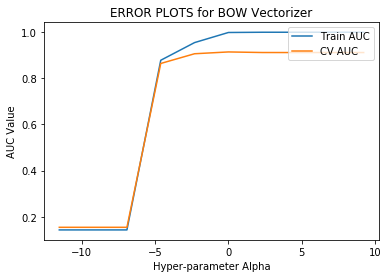

In [30]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(alpha_new,train_auc)
plt.plot(alpha_new,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Alpha')
plt.ylabel('AUC Value')
plt.show()

In [31]:
# Getting the optimal Alpha Based to CV AUC
optimal_lamda_auc = alpha[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best Alpha = %f' % optimal_lamda_auc)
print(best_cv_auc)

AUC Metric Best Alpha = 1.000000
0.915


In [32]:
# Applying Best K on D_Test

svm = SVC(random_state = 0, C = 1, class_weight='balanced',kernel = 'rbf', probability = True )
svm.fit(D2_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(svm.predict(D2_Test[j:j+1000]))
    predict_test_prob.extend(svm.predict_proba(D2_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(svm.predict(D2_Train[k:k+1000]))
    predict_train_prob.extend(svm.predict_proba(D2_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

7483
7483
Algo Run Successfully on D_Test


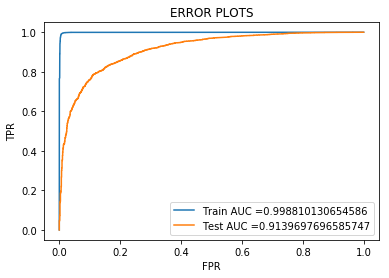

In [33]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [34]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
14921 79 282 20026
[[14921    79]
 [  282 20026]]
Test Confusion Matrix
800 543 306 5834
[[ 800  543]
 [ 306 5834]]


Text(0.5,1,'Confusion Matrix of Train Data')

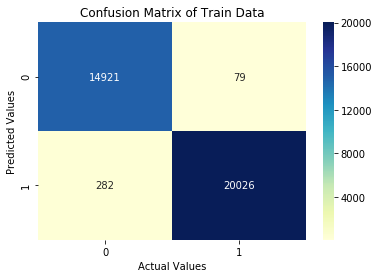

In [35]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

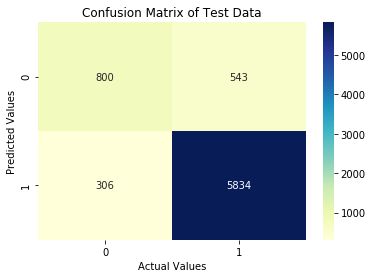

In [36]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

## 1.3) Applying Logistic Regression on Average_Word2Vec, SET 3

In [37]:
# Creating Word2Vec model on Training Data 

list_of_sentence_w2v = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence_w2v.append(sentence.split())
print(len(list_of_sentence_w2v))

# Creating Word2Vec model with 50 dimension and min_count=5, it will consider the word only if it appeared more than 5 times

w2v_model = Word2Vec(list_of_sentence_w2v, min_count=5, size=50, workers=4)
print(w2v_model.wv.most_similar("good"))
print("="*100)

w2v_words = list(w2v_model.wv.vocab)
print("Total Words Present ", len(w2v_words))
print("Sample Words : ", w2v_words[0:10])
print("="*100)

35308
[('great', 0.7676036357879639), ('bad', 0.7352327108383179), ('decent', 0.7326608896255493), ('awesome', 0.7072588205337524), ('terrific', 0.7009645700454712), ('fantastic', 0.6643946766853333), ('amazing', 0.6580710411071777), ('fabulous', 0.648877739906311), ('perky', 0.6419084072113037), ('awful', 0.6270285844802856)]
Total Words Present  12389
Sample Words :  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody']


In [39]:
# Fitting Average Word2Vec Model on Train Data

sent_vect_train = []
for sent in tqdm(list_of_sentence_w2v):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_train.append(sentence_vec)
print(len(sent_vect_train))
print(sent_vect_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 35308/35308 [01:43<00:00, 341.05it/s]


35308
[ 0.27060881 -0.32823568  0.19338272 -0.15602914 -0.4590505  -0.08977718
  0.0636862  -0.42937598  0.48017675  0.19315948  0.38800425  0.18836895
  0.11848439 -0.34882788  0.22884186  0.32566196  0.30434442 -0.020688
  0.06287416  0.11268584  0.3403602   0.08700429  0.67134427 -0.44806751
  0.66732525  0.54325271  0.03134542 -0.16041191  0.77567926 -0.29857864
  0.45084681 -0.48050503 -0.07824148  0.164813   -0.11623404  0.4110286
  0.31438083  0.47147773  0.04519112 -0.00598114 -0.37721292  0.34609095
 -0.29331916 -0.48830851  0.67633917 -0.51136914  0.01865011 -0.36399278
 -0.36511272 -0.4503982 ]


In [40]:
list_of_sentence_w2v = []
for sentence in X_1_cv['Cleaned_Text']:
    list_of_sentence_w2v.append(sentence.split())
print(len(list_of_sentence_w2v))

5987


In [41]:
# Fitting Average Word2Vec Model on Train Data

sent_vect_cv = []
for sent in tqdm(list_of_sentence_w2v):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_cv.append(sentence_vec)
print(len(sent_vect_cv))
print(sent_vect_cv[0])

100%|█████████████████████████████████████████████████████████████████████████████| 5987/5987 [00:17<00:00, 340.35it/s]


5987
[-0.16904604 -0.38458246 -1.0996619  -0.73001359 -0.92116623 -0.04964264
 -0.19858005 -0.76984166  0.56835132  0.23069311  0.37470553  0.06241505
 -0.11840632  0.61212092 -0.13183858 -0.35703844  0.1079141   0.08167603
 -0.39330484 -0.38900834  0.07070256  0.75043399  0.24123787 -0.34303024
  0.65264706  0.89870345  0.70887716 -0.00153372  0.96904205  0.07028119
 -0.18221226 -0.18721199 -0.06577569  0.49261821  0.01299059  0.38005827
 -0.01669093  0.03560516 -0.29901149 -0.08805083 -0.69119775  0.11716311
  0.22706906 -1.09359544  0.51773066 -0.09869457  0.2959564  -0.29139018
 -0.27539404 -0.43649629]


In [42]:
# Applying Word2Vec for Vectorization of X_test

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

7483


In [43]:
# Creating Average Word2Vec Vector for Test Data

sent_vect_test = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_test.append(sentence_vec)
print(len(sent_vect_test))
print(sent_vect_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 7483/7483 [00:21<00:00, 352.68it/s]


7483
[-0.1331956  -0.37837218 -0.09922468 -0.28637378  0.56479571  0.16741523
  1.28935429 -0.97433824  0.07770403  0.41006059  0.35554941  0.8611682
  0.66870815 -0.89995112 -0.18288778 -0.06301893  0.42507423  0.22240725
  0.91194578 -0.36393584  0.64626363  0.45447514  0.3188086  -0.09207566
  0.90898038  0.42618475  0.28662121 -1.4877507   0.36116398  0.30919251
 -0.16764364  0.02545224  0.05616166  1.28694863  0.22841608 -0.37418272
  0.51246241  0.28921958 -0.35222276  0.31407597  0.29552127  0.43408433
  0.42843166 -0.17449473  0.30175796  0.12389303 -0.61906465 -0.61391273
 -0.23922335 -1.02344792]


In [44]:
n_train = len(sent_vect_train)
n_test = len(sent_vect_test)
n_cv = len(sent_vect_cv)
print(n_train)
print(n_test)

35308
7483


In [45]:
# Standardization Process when we are not doing Feature Engineering

scaler = StandardScaler()
scaler.fit(sent_vect_train)
D3_Train = scaler.transform(sent_vect_train)
D3_Test = scaler.transform(sent_vect_test)
D3_Cv= scaler.transform(sent_vect_cv)

print(D3_Train.shape)
print(D3_Test.shape)
print(D3_Cv.shape)

(35308, 50)
(7483, 50)
(5987, 50)


In [46]:
# Applying SVM

cv_score = []
train_score = []

# creating hyper-parameter list
alpha = list((0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000))

cv_auc = []
train_auc = []
        
for i in tqdm(alpha):
    svm = SVC(random_state = 0, C = i, class_weight='balanced',kernel = 'rbf', probability = True )
    
    # Fitting the model in Train - CrossValidation
    svm.fit(D3_Train,Y_1_train)
    
    predict_cv_prob = []
    predict_train_prob = []
    predicted_labels_test = []
    predicted_labels_train = []
        
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_test.extend(svm.predict(D3_Cv[j:j+1000]))
        predict_cv_prob.extend(svm.predict_proba(D3_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(svm.predict(D3_Train[k:k+1000]))
        predict_train_prob.extend(svm.predict_proba(D3_Train[k:k+1000])[:,1])
    
    print(len(predict_train_prob))
        
    cv_auc.append(roc_auc_score(Y_1_cv,predict_cv_prob))
    train_auc.append(roc_auc_score(Y_1_train,predict_train_prob))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

35308


 10%|███████▉                                                                       | 1/10 [28:29<4:16:21, 1709.00s/it]

35308


 20%|███████████████▊                                                               | 2/10 [56:53<3:47:41, 1707.65s/it]

35308


 30%|███████████████████████                                                      | 3/10 [1:30:31<3:30:04, 1800.67s/it]

35308


 40%|██████████████████████████████▊                                              | 4/10 [1:57:33<2:54:42, 1747.01s/it]

35308


 50%|██████████████████████████████████████▌                                      | 5/10 [2:18:31<2:13:22, 1600.53s/it]

35308


 60%|██████████████████████████████████████████████▏                              | 6/10 [2:39:40<1:40:03, 1500.89s/it]

35308


 70%|█████████████████████████████████████████████████████▉                       | 7/10 [3:13:11<1:22:42, 1654.05s/it]

35308


 80%|█████████████████████████████████████████████████████████████▌               | 8/10 [4:35:57<1:28:15, 2647.61s/it]

35308


 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [6:07:18<58:17, 3497.68s/it]

35308


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [7:30:14<00:00, 3941.19s/it]


In [47]:
import math
alpha_new = []
for n in range(len(alpha)):
    alpha1 = alpha[n]
    x = math.log(alpha1)
    print(alpha1,x)
    alpha_new.append(x)

1e-05 -11.512925464970229
0.0001 -9.210340371976182
0.001 -6.907755278982137
0.01 -4.605170185988091
0.1 -2.3025850929940455
1 0.0
10 2.302585092994046
100 4.605170185988092
1000 6.907755278982137
10000 9.210340371976184


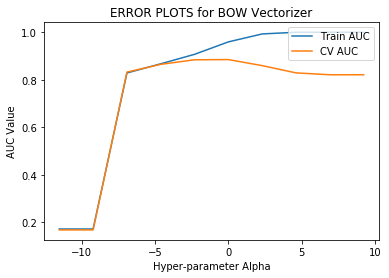

In [48]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(alpha_new,train_auc)
plt.plot(alpha_new,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Alpha')
plt.ylabel('AUC Value')
plt.show()

In [49]:
# Getting the optimal Alpha Based to CV AUC
optimal_lamda_auc = alpha[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best Alpha = %f' % optimal_lamda_auc)
print(best_cv_auc)

AUC Metric Best Alpha = 1.000000
0.885


In [50]:
# Applying Best K on D_Test

svm = SVC(random_state = 0, C = 1, class_weight='balanced',kernel = 'rbf', probability = True )
svm.fit(D3_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(svm.predict(D3_Test[j:j+1000]))
    predict_test_prob.extend(svm.predict_proba(D3_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(svm.predict(D3_Train[k:k+1000]))
    predict_train_prob.extend(svm.predict_proba(D3_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

7483
7483
Algo Run Successfully on D_Test


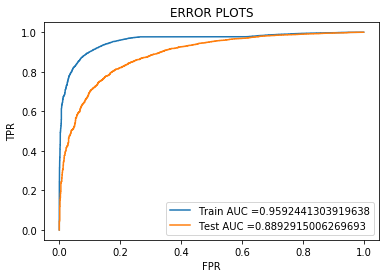

In [51]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [52]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
13911 1089 2620 17688
[[13911  1089]
 [ 2620 17688]]
Test Confusion Matrix
1014 329 909 5231
[[1014  329]
 [ 909 5231]]


Text(0.5,1,'Confusion Matrix of Train Data')

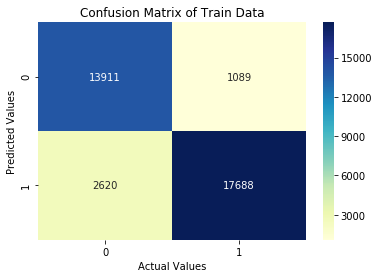

In [53]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

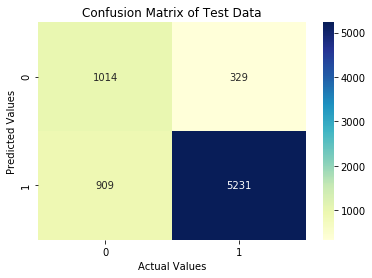

In [54]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

## 1.4) Applying Logistic Regression on Tf-Idf_Weighted-Average_Word2Vec, SET 4

##### We are using the previously created Tf-Idf and Word2Vec vectorizer .

In [55]:
# Splitting the Training Data into sentences
list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

35308


In [56]:
# Tf-Idf Weighted Word2Vec for Training Data

tf_idf_features = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

tfidf_w2v_train = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_train.append(sent_vec)
print(len(tfidf_w2v_train))

100%|███████████████████████████████████████████████████████████████████████████| 35308/35308 [02:01<00:00, 291.72it/s]


35308


In [59]:
# Splitting the Test Data into sentences

list_of_sentence = []
for sentence in X_1_cv['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

5987


In [60]:
# Tf-Idf Weighted Word2Vec for Test Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_cv = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_cv.append(sent_vec)
print(len(tfidf_w2v_cv))

100%|█████████████████████████████████████████████████████████████████████████████| 5987/5987 [00:21<00:00, 280.37it/s]


5987


In [57]:
# Splitting the Test Data into sentences

list_of_sentence = []X_1_cv
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

7483


In [58]:
# Tf-Idf Weighted Word2Vec for Test Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_test = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_test.append(sent_vec)
print(len(tfidf_w2v_test))

100%|█████████████████████████████████████████████████████████████████████████████| 7483/7483 [00:27<00:00, 271.33it/s]


7483


In [61]:
n_train = len(tfidf_w2v_train)
n_test = len(tfidf_w2v_test)
n_cv = len(tfidf_w2v_cv)
print(n_train)
print(n_test)

35308
7483


In [62]:
# Standardization Process

scaler = StandardScaler()
scaler.fit(tfidf_w2v_train)
D4_Train = scaler.transform(tfidf_w2v_train)
D4_Test = scaler.transform(tfidf_w2v_test)
D4_Cv = scaler.transform(tfidf_w2v_cv)

print(D4_Train.shape)
print(D4_Test.shape)

(35308, 50)
(7483, 50)


In [63]:
# Applying SVM

cv_score = []
train_score = []

# creating hyper-parameter list
alpha = list((0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000))

cv_auc = []
train_auc = []
        
for i in tqdm(alpha):
    svm = SVC(random_state = 0, C = i, class_weight='balanced',kernel = 'rbf', probability = True )
    
    # Fitting the model in Train - CrossValidation
    svm.fit(D4_Train,Y_1_train)
    
    predict_cv_prob = []
    predict_train_prob = []
    predicted_labels_test = []
    predicted_labels_train = []
        
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_test.extend(svm.predict(D4_Cv[j:j+1000]))
        predict_cv_prob.extend(svm.predict_proba(D4_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(svm.predict(D4_Train[k:k+1000]))
        predict_train_prob.extend(svm.predict_proba(D4_Train[k:k+1000])[:,1])
    
    print(len(predict_train_prob))
        
    cv_auc.append(roc_auc_score(Y_1_cv,predict_cv_prob))
    train_auc.append(roc_auc_score(Y_1_train,predict_train_prob))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

35308


 10%|███████▉                                                                       | 1/10 [26:23<3:57:35, 1583.90s/it]

35308


 20%|███████████████▊                                                               | 2/10 [52:39<3:30:50, 1581.31s/it]

35308


 30%|███████████████████████                                                      | 3/10 [1:18:53<3:04:14, 1579.22s/it]

35308


 40%|██████████████████████████████▊                                              | 4/10 [1:40:55<2:30:12, 1502.04s/it]

35308


 50%|██████████████████████████████████████▌                                      | 5/10 [2:00:11<1:56:31, 1398.24s/it]

35308


 60%|██████████████████████████████████████████████▏                              | 6/10 [2:24:06<1:33:57, 1409.38s/it]

35308


 70%|█████████████████████████████████████████████████████▉                       | 7/10 [3:05:59<1:27:01, 1740.50s/it]

35308


 80%|█████████████████████████████████████████████████████████████▌               | 8/10 [5:17:08<1:59:17, 3578.89s/it]

35308


 90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [7:51:48<1:28:09, 5289.31s/it]

35308


100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [10:10:22<00:00, 6196.65s/it]


In [64]:
import math
alpha_new = []
for n in range(len(alpha)):
    alpha1 = alpha[n]
    x = math.log(alpha1)
    print(alpha1,x)
    alpha_new.append(x)

1e-05 -11.512925464970229
0.0001 -9.210340371976182
0.001 -6.907755278982137
0.01 -4.605170185988091
0.1 -2.3025850929940455
1 0.0
10 2.302585092994046
100 4.605170185988092
1000 6.907755278982137
10000 9.210340371976184


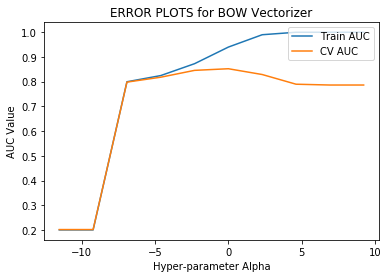

In [65]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(alpha_new,train_auc)
plt.plot(alpha_new,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Alpha')
plt.ylabel('AUC Value')
plt.show()

In [66]:
# Getting the optimal Alpha Based to CV AUC
optimal_lamda_auc = alpha[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best Alpha = %f' % optimal_lamda_auc)
print(best_cv_auc)

AUC Metric Best Alpha = 1.000000
0.852


In [67]:
# Applying Best K on D_Test

svm = SVC(random_state = 0, C = 1, class_weight='balanced',kernel = 'rbf', probability = True )
svm.fit(D4_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(svm.predict(D4_Test[j:j+1000]))
    predict_test_prob.extend(svm.predict_proba(D4_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(svm.predict(D4_Train[k:k+1000]))
    predict_train_prob.extend(svm.predict_proba(D4_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

7483
7483
Algo Run Successfully on D_Test


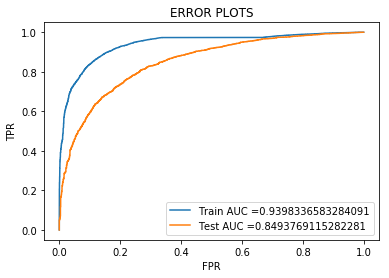

In [68]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [69]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
13532 1468 3332 16976
[[13532  1468]
 [ 3332 16976]]
Test Confusion Matrix
966 377 1141 4999
[[ 966  377]
 [1141 4999]]


Text(0.5,1,'Confusion Matrix of Train Data')

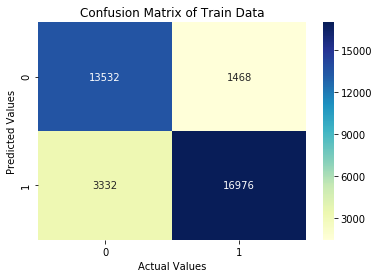

In [70]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

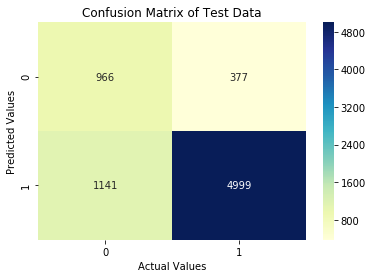

In [71]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

### Conclusion

In [73]:
# Importing Pretty Table
from prettytable import PrettyTable

In [77]:
x = PrettyTable()
x.field_names = ['Vectorizer', 'Hyper-Parameter Alpha','AUC']
x.add_row(['BOW','0.1','0.90'])
x.add_row(['Tf-Idf','1','0.91'])
x.add_row(['Average Word2Vec','1','0.89'])
x.add_row(['Tf-Idf_Average_Word2Vec','1','0.85'])

print(x)

+-------------------------+-----------------------+------+
|        Vectorizer       | Hyper-Parameter Alpha | AUC  |
+-------------------------+-----------------------+------+
|           BOW           |          0.1          | 0.90 |
|          Tf-Idf         |           1           | 0.91 |
|     Average Word2Vec    |           1           | 0.89 |
| Tf-Idf_Average_Word2Vec |           1           | 0.85 |
+-------------------------+-----------------------+------+


#### We have sampled top 40k datapoints that are highly imbalanced. We have thus balanced only the train datapoints with upsampling the negetive point. We also used the class_weight = balanced parameter of SVC function.

#### We have used the min_df = 10, max_features = 500 values for BOW and TFIDF vectorizer so that the run time of the algorithm is still manageable.